<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'C:/Users/Polly/Documents/Roma/Python/Coursera/MO-Phistekch/06/Identification' 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [53]:
def count_n_unique(array):
    unique_sites = np.unique(array)
    if 0 in unique_sites:
        return len(unique_sites) - 1
    else:
        return len(unique_sites)

def get_session_timespan(timestamps, session_length, window_size):
    session_timespan = []
    for i in range(0, len(timestamps), window_size):
        try:
            session_timespan.append(int((timestamps[session_length - 1 + i] - timestamps[i]).total_seconds()))
        except KeyError:
            session_timespan.append(int((timestamps.iloc[-1] - timestamps[i]).total_seconds()))
    return np.array(session_timespan)
    

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    sites_freq = pickle.load(open(site_freq_path, 'rb'))
    files = glob(os.path.join(path_to_csv_files, '*.csv'))

    data_array = np.empty((0, len(feature_names)), int)
    
    for file in tqdm(files):
        user_df = pd.read_csv(file)
        user_sites = user_df.site.values
        user_sites_ids = []
        
        # переводим данные о времени посещения сайтов в формат datetime
        timestamps = pd.to_datetime(user_df.timestamp)
        
        for site in user_sites:
            site_id = sites_freq[site][0]
            user_sites_ids.append(site_id)
        
        # добавляем нули в конце сессии при необходимости
        if len(user_sites_ids) % window_size != 0:
            user_sites_ids = np.pad(user_sites_ids, (0, session_length - len(user_sites_ids) % window_size), 'constant')
        remainder = (len(user_sites_ids) - ((len(user_sites_ids) / window_size) - 1) * window_size) % session_length
        if remainder != 0:
            user_sites_ids = np.pad(user_sites_ids, (0, session_length - int(remainder)), 'constant')
                              
        user_sites_ids = np.vstack([user_sites_ids[i:session_length+i] for i in range(0, len(user_sites), window_size)])
        
        # создаем признак session_timespan для сессий пользователя
        session_timespan = get_session_timespan(timestamps, session_length, window_size)
        session_timespan = np.reshape(session_timespan, [user_sites_ids.shape[0], -1])

        # создаем признак n_unique для сессий пользователя      
        n_unique = np.apply_along_axis(count_n_unique, axis=1, arr=user_sites_ids)
        n_unique = np.reshape(n_unique, [user_sites_ids.shape[0], -1])
        
        # создаем признак start_hour для сессий пользователя      
        start_hour = np.array([timestamps[i].hour for i in range(0, len(user_sites), window_size)])
        start_hour = np.reshape(start_hour, [user_sites_ids.shape[0], -1])
        
        # создаем признак day_of_week для сессий пользователя      
        day_of_week = np.array([timestamps[i].dayofweek for i in range(0, len(user_sites), window_size)])
        day_of_week = np.reshape(day_of_week, [user_sites_ids.shape[0], -1])

        # создаем столбец с id пользователя 
        user_id = int(os.path.splitext(file)[0][-4:])
        user_ids = np.array([user_id for i in range(user_sites_ids.shape[0])])
        user_ids = np.reshape(user_ids, [user_sites_ids.shape[0], -1])
        
        #объединяем все столбцы по пользователю
        user_data_array = np.hstack([user_sites_ids, session_timespan, n_unique, start_hour, day_of_week, user_ids])
        
        # объединяем матрицу с признаками по текущему пользователю с общей матрицей по всем пользователям
        data_array = np.vstack([data_array, user_data_array])    
    
    df = pd.DataFrame(data_array, columns=feature_names)
    

    return df


**Проверим функцию на игрушечном примере.**

In [54]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 90.85it/s]


In [55]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,4,2,2,11,2,1,8,5,9,10,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,5,7,3,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [56]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████| 10/10 [00:02<00:00,  3.81it/s]


Wall time: 2.77 s


In [57]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [58]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████| 150/150 [00:27<00:00,  6.96it/s]


Wall time: 27.5 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [59]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']]

In [60]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [61]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [62]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

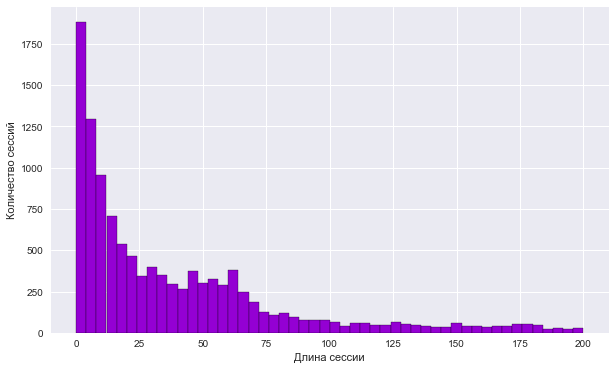

In [47]:
plt.figure(num=None, figsize=(10, 6))

# увеличил параметр bins для большей точности графика
plt.hist(x=train_data_10users['session_timespan'].values, range=(0,200), bins=50, color='darkviolet')
plt.xlabel('Длина сессии')
plt.ylabel('Количество сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

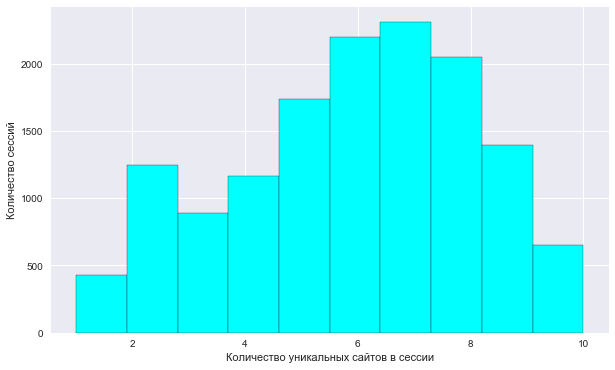

In [21]:
plt.figure(num=None, figsize=(10, 6))

train_data_10users['#unique_sites'].plot(kind='hist', color='aqua')
plt.xlabel('Количество уникальных сайтов в сессии')
plt.ylabel('Количество сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

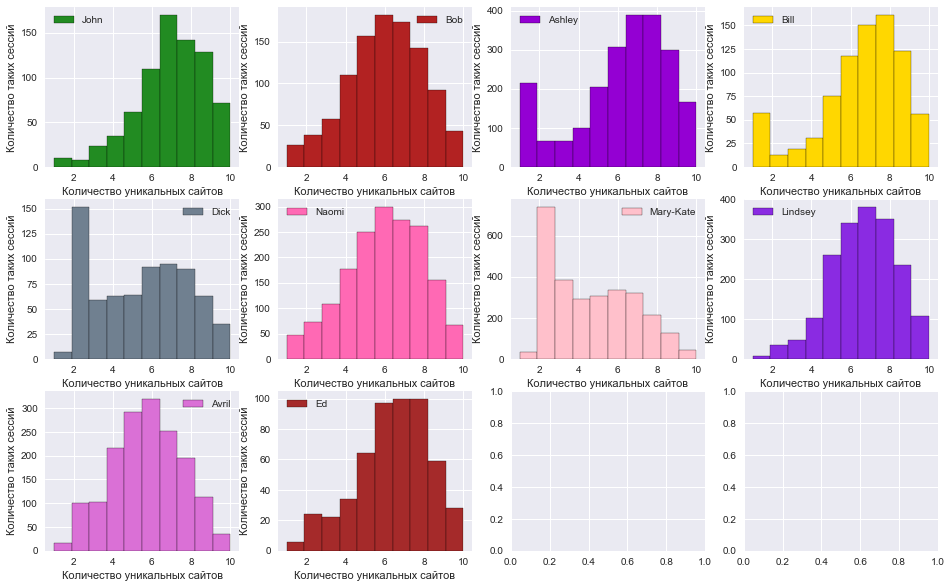

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    user_name = sub_df['target'].values[0]
    axes[idx//4,idx%4].hist(sub_df['#unique_sites'],color=color_dic[user_name])
    axes[idx//4,idx%4].set_xlabel('Количество уникальных сайтов')
    axes[idx//4,idx%4].set_ylabel('Количество таких сессий')
    axes[idx//4,idx%4].legend(labels=[user_name])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

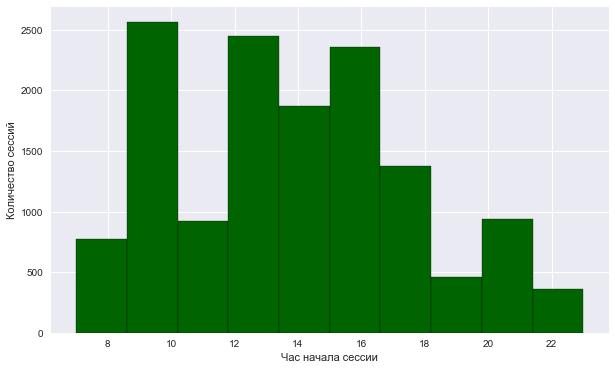

In [22]:
plt.figure(num=None, figsize=(10, 6))

train_data_10users['start_hour'].plot(kind='hist', color='darkgreen')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

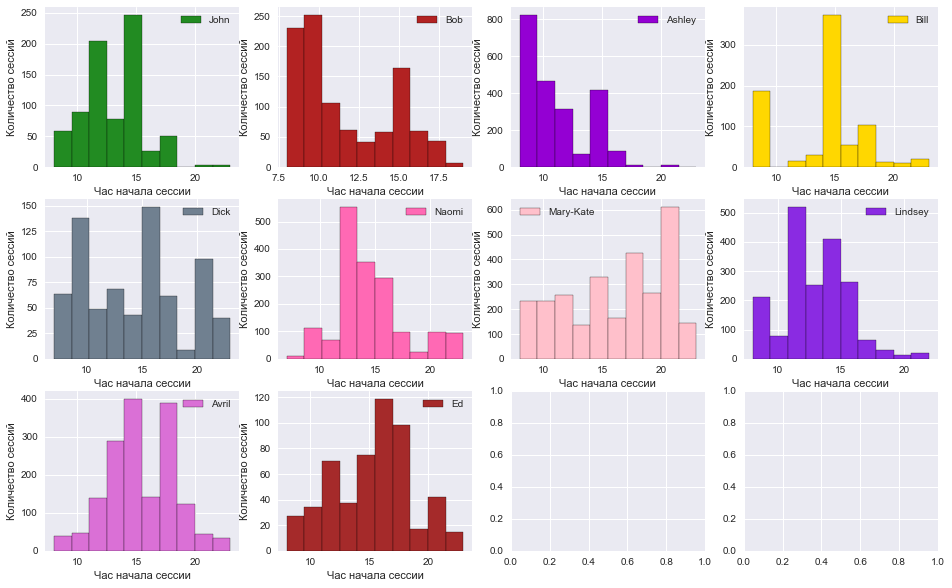

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    user_name = sub_df['target'].values[0]
    axes[idx//4,idx%4].hist(sub_df['start_hour'],color=color_dic[user_name])
    axes[idx//4,idx%4].set_xlabel('Час начала сессии')
    axes[idx//4,idx%4].set_ylabel('Количество сессий')
    axes[idx//4,idx%4].legend(labels=[user_name])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

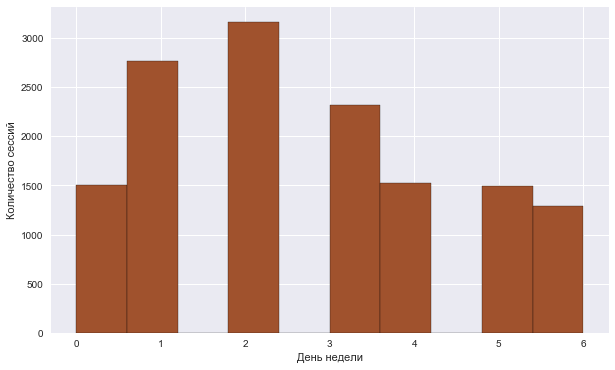

In [23]:
plt.figure(num=None, figsize=(10, 6))


train_data_10users['day_of_week'].plot(kind='hist', color='sienna')
plt.xlabel('День недели')
plt.ylabel('Количество сессий')


**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

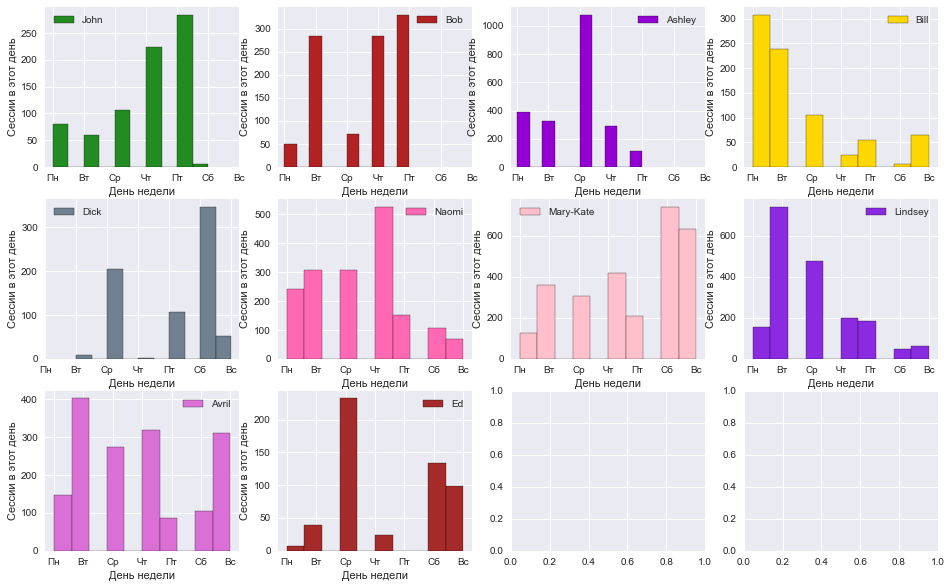

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    user_name = sub_df['target'].values[0]
    axes[idx//4,idx%4].hist(sub_df['day_of_week'],color=color_dic[user_name])
    axes[idx//4,idx%4].set_xlabel('День недели')
    axes[idx//4,idx%4].set_ylabel('Сессии в этот день')
    axes[idx//4,idx%4].set_xticks([0, 1, 2, 3, 4, 5, 6])
    axes[idx//4,idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])    
    axes[idx//4,idx%4].legend(labels=[user_name])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. **John**. Пользуется в основном в рабочее время, почти только в будние дни. Что интересно, в четверг и пятницу больше всего сессий. И у нее довольно много уникальных сайтов в сессии.
2. **Bob**. Сессии только в буднии дни. Максимум во вторник, четверг и пятницу. Пик по времени - ранним утром (до 10 утра), видимо перед работой и днем,  15 до 16 (возможно, обеденный перерыв?). После 17:30 почти нет сессий. Количество уникальных сайтов в сесси - приблизительно среднее.
3. **Ashley**. Сессии только в буднии дни, сильный выделяющийся пик в среду. Основное количество сессий - в первую половину дня (особенно в 9-10 часов) и около 15 часов. Довольно много сессий, в которые был посещен только один уникальный сайт (больше, чем у других пользователей).
4. **Bill**. Больше всего сессий в понедельник-вторник. Есть сессии и в выходные - в воскресенье около 50. По времени пик около 15 часов, и довольно много до 10 часов. Есть заметное количество сессий, когда был посещен только 1 уникальный сайт, но в остально преобладают сессии, где 6-8 уникальных сайтов.
5. **Dick**. Больше всего сессий в субботу, а вот в понедельник и четверг их почти совсем нет. По времени - почти нет сессий с 19 до 20, пики: до 10, до 16 и  21 часа. Много сессий, где всего 2 уникальных сайта, почти нет, где 1, приблизительно схоже - где больше двух. 
6. **Naomi**. Пик сессий в четверг, а в пятницу, субботу и воскресенье сессий меньше всего. Больше всего сессий днем. Мало сессий с 1-4 уникальными сайтами в сессии, в основном от 4 до 8.
7. **Mary-Kate**. Больше всего сессий в субботу и воскресенье. Больше всего сессий, которые начинаются приблизительно в 20-21, но и в течение дня довольно много. Довольно мало уникальных сайтов в среднем в сессию, преобладают сессии с 2 уникальными сайтами. 
8. **Lindsey**. Мало сессий в выходные. Пик во вторник, относительно много в среду. Вечером почти нет. Больше всего - днем, довольно много - утром. Мало сессий с 1-4 уникальными сайтами в сессии.
9. **Avril**. Как минимум 50 в каждый день, больше всего во вторник, но и в среду, четверг и воскресенье много. Пики по времени - днем, утром и вечером совсем мало. Распределение количества уникальных сайтов в сессии похоже на нормальное - чаще всего по 5-6 уникальных сайтов в сессию.
10. **Ed**. Пик в среду, но и в субботу и воскресенье много сессий. Больше всего с 14 до 19, в другое время тоже есть. Преобладают сессии с количеством уникальных сайтов больше 5.
<br>

Общий вывод - признаки позволяют разграничивать пользователей, но это пока пользователей 10. Не понятно, насколько эффективно они будут работать при 150 или 3000 пользователей. 

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [26]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as f:
    freq_dict_10 = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
sites = pd.DataFrame.from_dict(freq_dict_10, orient='index')

sorted_sites = sites.sort_values(by=1, axis=0, ascending=False, kind='mergesort')
sites.columns = ['id', 'views']

sorted_sites.columns = ['id', 'views']

top10_freqs = sorted_sites.views.values[:10]
top10_sites = np.array(sorted_sites.index[:10])

In [186]:
top10_freqs

array([8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089], dtype=int64)

In [28]:
top10_sites

array(['s.youtube.com', 'www.google.fr', 'www.google.com',
       'mail.google.com', 'www.facebook.com', 'apis.google.com',
       'r3---sn-gxo5uxg-jqbe.googlevideo.com',
       'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com',
       'accounts.google.com'], dtype=object)

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

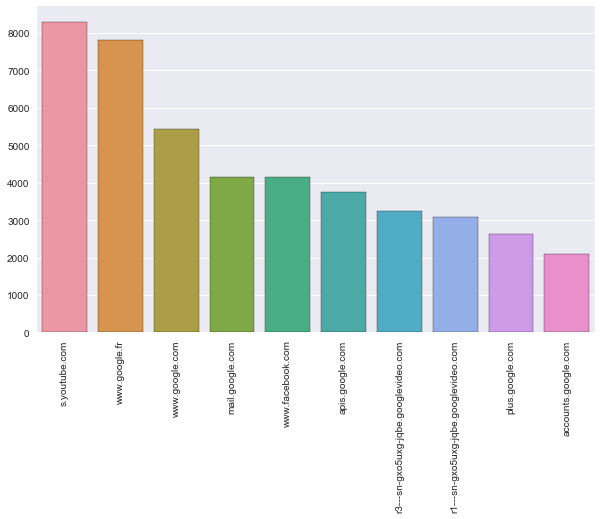

In [29]:
plt.figure(num=None, figsize=(10, 6))

top10_barplot = sns.barplot(x=top10_sites, y=top10_freqs)
plt.setp(top10_barplot.get_xticklabels(), rotation=90);

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [30]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [33]:
train_data_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [35]:
train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [36]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Создаю бинарный признак - является ли день начала сессии выходным, 
категориальный признак - время дня (ночь/утро, вечер или день), 
и признак - разница между количеством сайтов в сессии, входящих в топ10 и не входящих

In [80]:
def top10(site_freq_path):
    sites_freq = pickle.load(open(site_freq_path, 'rb'))
    sites_freq = pd.DataFrame.from_dict(sites_freq, orient='index')
    sites_freq = sites_freq.sort_values(by=1, axis=0, ascending=False, kind='mergesort')
    sites_freq.columns = ['id', 'views']
    top10_sites = np.array(sites_freq.index[:10])
    return top10_sites


def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    
    top10_sites = top10(site_freq_path)
    files = glob(os.path.join(path_to_csv_files, '*.csv'))
    
    data_array = np.empty((0, len(features)), int)

    for file in tqdm(files):
        user_df = pd.read_csv(file)
        user_sites = user_df.site.values
        
        timestamps = pd.to_datetime(user_df.timestamp)
        
        is_weekend = np.array([0 if timestamps[i].dayofweek < 5 else 1 for i in range(0, len(user_sites), session_length)])
        is_weekend = np.reshape(is_weekend, [len(is_weekend), -1])
        
        time_of_day = []
        for i in range(0, len(user_sites), session_length):
            if timestamps[i].hour < 5:
                time_of_day.append(0)
            if timestamps[i].hour < 10:
                time_of_day.append(1)
            elif timestamps[i].hour < 19:
                time_of_day.append(2)
            else:
                time_of_day.append(3)
        time_of_day = np.array(time_of_day)
        time_of_day = np.reshape(time_of_day, [len(time_of_day), -1])
        
        visited_top10 = []
        for site in user_sites:
            if site in top10_sites:
                visited_top10.append(1)
            else: 
                visited_top10.append(-1)
                
        if len(user_sites) % session_length != 0:
            visited_top10 = np.pad(visited_top10, (0, session_length - len(visited_top10) % session_length), 'constant')
        visited_top10 = np.reshape(visited_top10, [-1, session_length])

        proportion_top10 = np.apply_along_axis(sum, axis=1, arr=visited_top10)
        proportion_top10 = np.reshape(proportion_top10, [len(proportion_top10), -1])
        
        new_features = np.hstack([is_weekend, time_of_day, proportion_top10])
        
        data_array = np.vstack([data_array, new_features])  

    return pd.DataFrame(data_array, columns=features)

features = ['is_weekend', 'time_of_day', 'proportion_top10']

In [81]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           features=features)

100%|██████████████████████████████████████████| 10/10 [00:02<00:00,  3.97it/s]


Wall time: 2.64 s


In [82]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           features=features)

100%|████████████████████████████████████████| 150/150 [00:26<00:00,  7.08it/s]


Wall time: 26.4 s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [83]:
train_data_10users[features] = new_features_10users

In [84]:
train_data_150users[features] = new_features_150users

Сравниваю час начала сессии в будние дни и в выходные

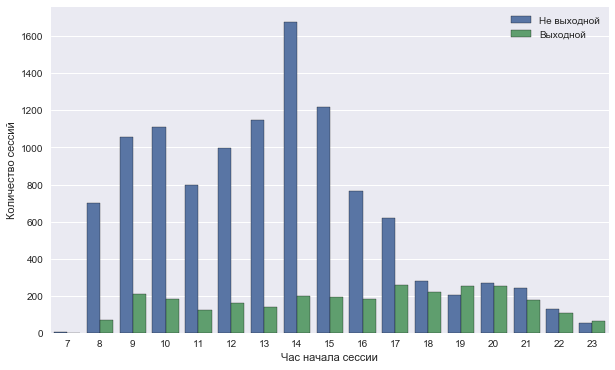

In [85]:
plt.figure(num=None, figsize=(10, 6))

sns.countplot(x='start_hour', hue='is_weekend',
                            data=train_data_10users)

plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий')
plt.legend(labels=['Не выходной', 'Выходной'])

In [86]:
train_data_10users[['session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'is_weekend', 'time_of_day',
       'proportion_top10']].corr()

,session_timespan,#unique_sites,start_hour,day_of_week,is_weekend,time_of_day,proportion_top10
session_timespan,1.000000,0.022519,0.025345,-0.005698,-0.008473,0.023312,0.000628
#unique_sites,0.022519,1.000000,-0.123277,-0.224307,-0.232808,-0.128669,-0.314638
start_hour,0.025345,-0.123277,1.000000,0.221487,0.258091,0.827729,0.196610
day_of_week,-0.005698,-0.224307,0.221487,1.000000,0.777918,0.207397,0.205360
is_weekend,-0.008473,-0.232808,0.258091,0.777918,1.000000,0.218739,0.239021
time_of_day,0.023312,-0.128669,0.827729,0.207397,0.218739,1.000000,0.196845
proportion_top10,0.000628,-0.314638,0.196610,0.205360,0.239021,0.196845,1.000000


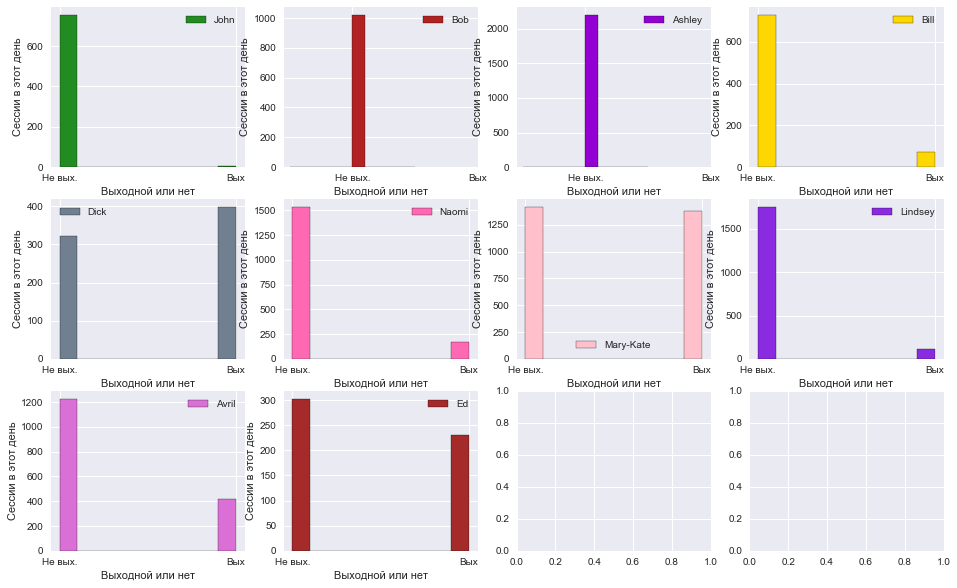

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    user_name = sub_df['target'].values[0]
    axes[idx//4,idx%4].hist(sub_df['is_weekend'],color=color_dic[user_name])
    axes[idx//4,idx%4].set_xlabel('Выходной или нет')
    axes[idx//4,idx%4].set_ylabel('Сессии в этот день')
    axes[idx//4,idx%4].set_xticks([0, 1])
    axes[idx//4,idx%4].set_xticklabels(['Не вых.', 'Вых'])    
    axes[idx//4,idx%4].legend(labels=[user_name])

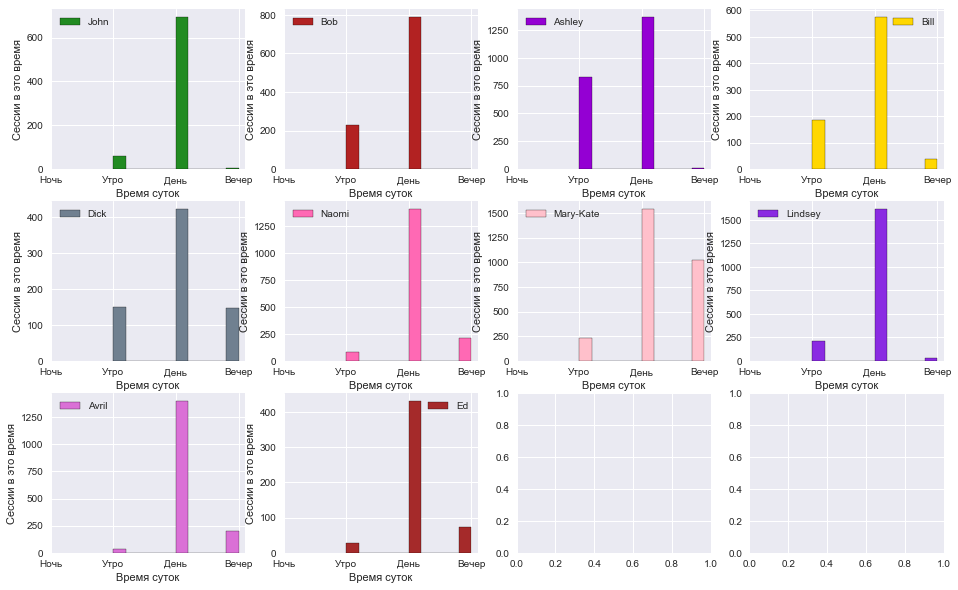

In [87]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    user_name = sub_df['target'].values[0]
    axes[idx//4,idx%4].hist(sub_df['time_of_day'],color=color_dic[user_name])
    axes[idx//4,idx%4].set_xlabel('Время суток')
    axes[idx//4,idx%4].set_ylabel('Сессии в это время')
    axes[idx//4,idx%4].set_xticks([0, 1, 2, 3])
    axes[idx//4,idx%4].set_xticklabels(['Ночь', 'Утро', 'День', 'Вечер'])    
    axes[idx//4,idx%4].legend(labels=[user_name])

Эти признаки (время суток, день недели) позволяют категоризировать признаки часа старта сессии и дня неделя сессии. И помогают лучше визуализировать привычки пользователей. 

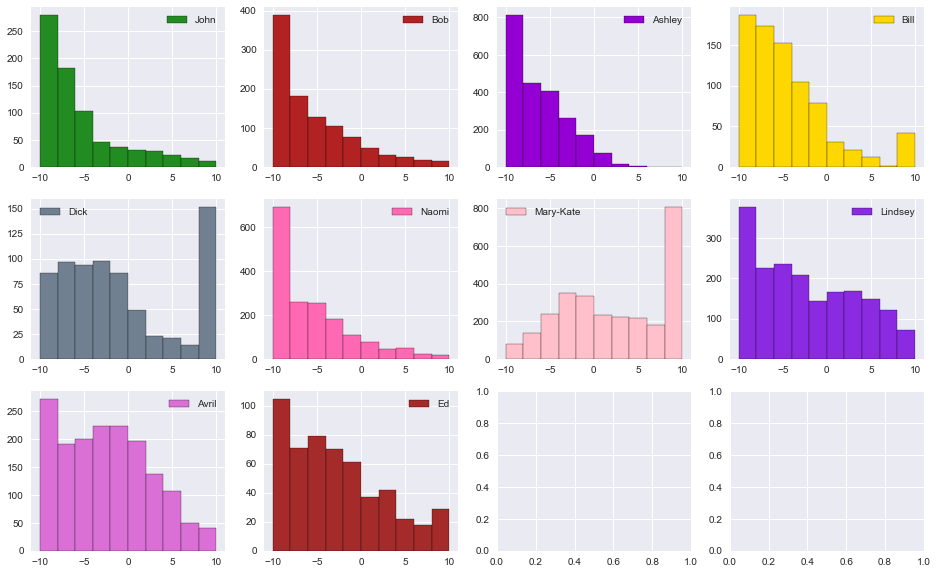

In [77]:
#Смотрю на то, сколько сайтов в сессии у пользователей - сайты из топ-10. 
#Значение признака 10 показывает, что все посещенные сайты входили в топ-10, значение -10 - что ни один из сайтов не входил. 

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    user_name = sub_df['target'].values[0]
    axes[idx//4,idx%4].hist(sub_df['proportion_top10'],color=color_dic[user_name])
    axes[idx//4,idx%4].set_xlabel('')
    axes[idx//4,idx%4].set_ylabel('')
 
    axes[idx//4,idx%4].legend(labels=[user_name])

Данный признак хорошо показывает разные привычки пользователей (кто-то больше заходит на популярные сайты, кто-то - реже). Дополняет наш признак с количеством уникальных сайтов в сессии.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [88]:
selected_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'is_weekend', 'time_of_day',
       'proportion_top10']]

selected_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'is_weekend', 'time_of_day',
       'proportion_top10']]

In [89]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 